# Task 3 - Feature Matching using SIFT

Write a function which takes an image from the same dataset for training
and testing as in the previous task.

**Main steps:**
1. You first extract keypoints and feature descriptors from your
Test and Train images using standard SIFT or SURF feature extraction
function from a library.
2. Then you match features between images which will give you the raw noisy matches (correspondences).
3. Now you should decide which geometric transform to use to reject the outliers. (using RANSAC)
4. Finally, you will
define a score on the obtained inlier matches and will use this to detect the
objects (icons) scoring high for a given Test image. A basic score is counting
the inlier matches.

**Output:**

Detect objects in the Test images using SIFT or equivalent features (such as SURF), recognize to which class they belong, and identify
their scales and orientations. Similar as Task2, for visual demonstration the
function should open a box around each detected object and indicate its class
label. This box is scaled and rotated according to the object’s scale and orientation. Demonstrate example images(s) of the outcome detection in your report. Besides, demonstrate example images(s) that shows the feature-based
matches established between the recognised objects and a Test image, before
and after the outlier refinement step.

**Evaluation:**

Evaluate your algorithm on all Test images to report the overall Intersection over Union (IoU), False Positive (FPR), True Positive (TPR) and
Accuracy (ACC) rates, as well as the average runtime. Refer to the following report http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_
doc.pdf section 4.4 for further information about the evaluation metrics.
Show and explain cases where this scheme finds difficulty to perform correctly. Compare the SIFT/SURF results to that of Task2 algorithm e.g.,
does it improve the overall speed or accuracy? How much? Why?

**Hyperparameter tuning:**

Similarly, you will have some hyper-parameters to tune. This includes the
number of Octaves and the (within-octave) Scalelevels within SIFT to build
scale-spaces for keypoint detection, and the MaxRatio parameter within the
matchFeatures function to reject weak matches. How are these parameters
set for this task? Show quantitatively why.

**Notes:**

For task 2 and task 3, you are allowed to use library functions for creating the pyramid or using Gaussian convolution. You are also allowed to use the library functions for extracting features, for e.g. extracting SIFT features. You are allowed to use math libraries, for instance svd functions for computing the homography.

You are *not* allowed to use the `cv2.matchTemplate` or `cv2.BFMatcher`.
- Basically functions for matching features need to be coded. 
- You would need to implement RANSAC also yourself.

[Explanation of SIFT](https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/)

### Imports & Constants

In [1]:
%load_ext autoreload
%autoreload 2

import task3
import logging
import cv2 as cv
import pandas as pd
import numpy as np
from typing import Dict, Tuple

from pathlib import Path
from task3 import ImageDataset, ObjectDetector, Verbosity, TutorialObjectDetector

QUERY_IMG_DIR = Path("IconDataset", "png")
TEST_IMG_DIR = Path("Task3Dataset", "today")

ANNOTATIONS_DIR = Path("Task3Dataset", "annotations")

# Configure basic logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s]::[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)

### Run detection pipeline on dataset

In [8]:
def detect_on_dataset(
        test_imgs: ImageDataset, 
        query_imgs: ImageDataset, 
        sift_hps: Dict = {},
        ransac_hps: Dict = {},
        lowe_threshold: float = 0.7,
        min_match_count: int = 10, 
        verbose: Verbosity = Verbosity.MEDIUM
    ) -> Tuple[float, ...]:

    acc_lst, tpr_list, fpr_lst, fnr_lst = [], [], [], []
    detector = TutorialObjectDetector(query_imgs, sift_hps, verbose=True, ransac_hyperparams=ransac_hps)

    # Iterate through each test image and detect objects in it. Compare these detctions to the ground truth annotations.
    for img, img_path in test_imgs:
        annotations_path = ANNOTATIONS_DIR / img_path.with_suffix(".csv").name
        img_annotations = pd.read_csv(annotations_path)

        print("\n", flush=True); logger.info(f"Detecting objects in {img_path.stem}")
        detections = detector.detect(img, lowe_threshold, min_match_count, draw=True)

        acc, tpr, fpr, fnr = task3.evaluate_detections(detections, img_annotations)
        acc_lst.append(acc); tpr_list.append(tpr); fpr_lst.append(fpr); fnr_lst.append(fnr)

    return np.mean(acc_lst), np.mean(tpr_list), np.mean(fpr_lst), np.mean(fnr_lst)

[2024-04-21 15:08:41,749]::[INFO] Detecting objects in test_image_19
[2024-04-21 15:08:41,828]::[INFO] Query image IconDataset/png/009-airport.png yields enough good matches - 10/10. Finding transform...
[2024-04-21 15:08:41,829]::[WARNING] An exception was raised while handling query image IconDataset/png/009-airport.png
OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

[2024-04-21 15:08:41,939]::[INFO] Query image IconDataset/png/041-windmill.png yields enough good matches - 21/10. Finding transform...


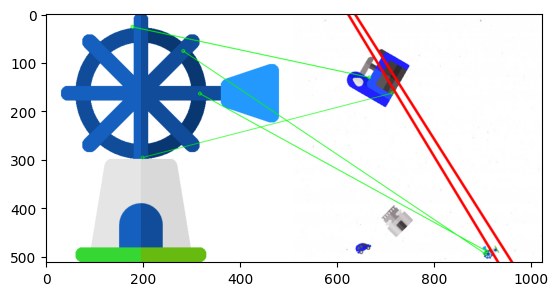

[2024-04-21 15:08:42,253]::[INFO] Query image IconDataset/png/026-shop.png yields enough good matches - 12/10. Finding transform...


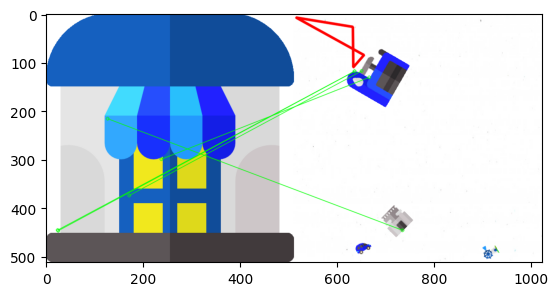

[2024-04-21 15:08:42,414]::[INFO] Query image IconDataset/png/002-bike.png yields enough good matches - 10/10. Finding transform...
[2024-04-21 15:08:42,415]::[WARNING] An exception was raised while handling query image IconDataset/png/002-bike.png
OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

[2024-04-21 15:08:42,907]::[INFO] Query image IconDataset/png/011-trash.png yields enough good matches - 30/10. Finding transform...
[2024-04-21 15:08:42,908]::[WARNING] An exception was raised while handling query image IconDataset/png/011-trash.png
OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

[2024-04-21 15:08:42,996]::[INFO] Query image IconDataset/png/015-barn.png yields enough good matches - 24/10. Finding transform...
[2024-04-21 15:08:42,997]::[WARNING] An exception was raised whi

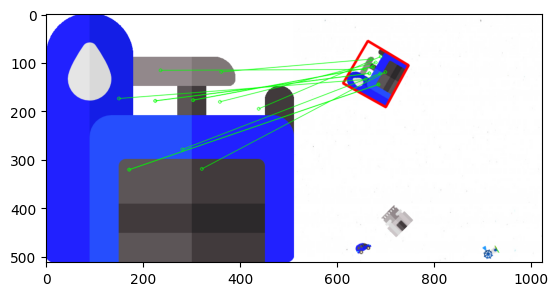

[2024-04-21 15:08:44,239]::[INFO] Query image IconDataset/png/019-prison.png yields enough good matches - 15/10. Finding transform...


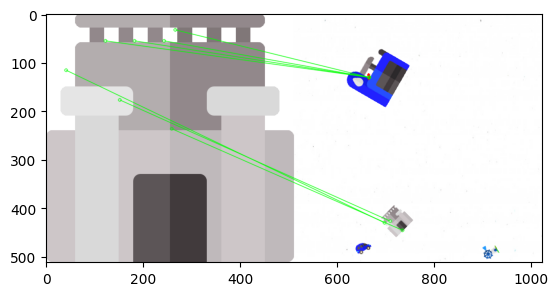

0.25 0.5 0.4 0.5


In [11]:
test_images = ImageDataset(TEST_IMG_DIR, file_ext="png")
query_images = ImageDataset(QUERY_IMG_DIR, file_ext="png")

acc, tpr, fpr, fnr = detect_on_dataset(test_images, query_images)
print(acc, tpr, fpr, fnr)

### Hyperparameter Optimisation

We'll use the following objective function to measure performance over a range of hyperparameters for `SIFT`, `RANSAC`, Lowe's Test, and minimum match counts. Then, using Bayesian optimisation, we'll minimise the function, hence we use '-accuracy'.

In [3]:
params = {"iteration": 30, "best_score": 0.40750000000000003, "parameters": {"sift_n_features": 164, "sift_n_octave_layers": 13, "sift_contrast_threshold": 0.05324885589798423, "sift_edge_threshold": 20.0, "sift_sigma": 3.127944957262645, "lowe_threshold": 0.6030571826480546, "min_match_count": 2, "ransac_max_iterations": 41, "ransac_threshold": 20.0}}['parameters']
init_params = [
    params['sift_n_features'], 
    params['sift_n_octave_layers'],
    params['sift_contrast_threshold'],
    params['sift_edge_threshold'],
    params['sift_sigma'],
    params['lowe_threshold'],
    params['min_match_count'],
    params['ransac_max_iterations'],
    params['ransac_threshold']
]

In [4]:
import json

import skopt
from tqdm.auto import tqdm
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt.callbacks import Callable


class NumpyEncoder(json.JSONEncoder):
    """Special json encoder for numpy types."""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    

class LogDisplayProgressCallback(Callable):

    def __init__(self, tqdm_obj, hyperparam_names: list):
        self.tqdm_obj = tqdm_obj
        self.hyperparam_names = hyperparam_names
        self.iteration = 1

    def __call__(self, result):
        self.tqdm_obj.update(1)

        # Since we are minimising negative accuracy.
        best_score = -result.fun 
        current_params = result.x
        
        result_data = {
            'iteration': self.iteration,
            'best_score': best_score,
            'parameters': dict(zip(self.hyperparam_names, current_params))
        }

        # Write params to JSON file for monitoring.
        with open('optimisation_log2.json', 'a') as f:
            json.dump(result_data, f, cls=NumpyEncoder)
            f.write(',\n')

        self.iteration += 1


# Define the hyperparameter space
space = [
    Integer(64, 164, name='sift_n_features'),
    Integer(1, 15, name='sift_n_octave_layers'),
    Real(0.005, 0.2, name='sift_contrast_threshold'),
    Real(0.1, 40.0, name='sift_edge_threshold'),
    Real(0.1, 5.0, name='sift_sigma'),
    Real(0.25, 2.0, name='lowe_threshold'),
    Integer(2, 50, name='min_match_count'),
    Integer(14, 100, name='ransac_max_iterations'),
    Real(1.0, 40.0, name='ransac_threshold'),
]

@use_named_args(space)
def objective_function(**params):
    sift_hps = {
        'nfeatures': params['sift_n_features'],
        'nOctaveLayers': params['sift_n_octave_layers'],
        'contrastThreshold': params['sift_contrast_threshold'],
        'edgeThreshold': params['sift_edge_threshold'],
        'sigma': params['sift_sigma'],
    }

    ransac_hps = {
        'max_iterations': params['ransac_max_iterations'],
        'threshold': params['ransac_threshold'],
    }

    acc, _, _, _ = detect_on_dataset(test_images, query_images, sift_hps, ransac_hps,
                                     params['lowe_threshold'],
                                     params['min_match_count'])
    
    # Negative because we minimise in the optimisation procedure.
    return -acc


ITERATIONS = 150

tqdm_o = tqdm(total=ITERATIONS)
callback = LogDisplayProgressCallback(tqdm_o, [param.name for param in space])

test_images = ImageDataset(TEST_IMG_DIR, file_ext="png")
query_images = ImageDataset(QUERY_IMG_DIR, file_ext="png")

result = gp_minimize(
    objective_function,
    dimensions=space,
    n_calls=ITERATIONS,
    # x0=[init_params],
    callback=[callback]
)

tqdm_o.close()

  0%|          | 0/150 [00:00<?, ?it/s]

[2024-04-20 13:46:13,662]::[WARNING] An exception was raised while handling query image IconDataset/png/048-hospital.png.
'NoneType' object has no attribute 'transform'
[2024-04-20 13:48:25,040]::[WARNING] An exception was raised while handling query image IconDataset/png/028-government.png.
'NoneType' object has no attribute 'transform'
[2024-04-20 13:48:42,850]::[WARNING] An exception was raised while handling query image IconDataset/png/028-government.png.
'NoneType' object has no attribute 'transform'
[2024-04-20 13:49:45,583]::[WARNING] An exception was raised while handling query image IconDataset/png/045-museum.png.
'NoneType' object has no attribute 'transform'
[2024-04-20 13:49:47,922]::[WARNING] An exception was raised while handling query image IconDataset/png/045-museum.png.
'NoneType' object has no attribute 'transform'
[2024-04-20 13:49:50,238]::[WARNING] An exception was raised while handling query image IconDataset/png/045-museum.png.
'NoneType' object has no attribute 